<a href="https://colab.research.google.com/github/linyuehzzz/census_privacy/blob/main/cell_uniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


#### **Read synthetic population data**

In [2]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import pandas as pd

filename_people = 'franklin/microdata/franklin_peoplev0.csv'
data_people = pd.read_csv(filename_people)
data_people

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,GEOID10,PUMAID,SEX,RAC1P,AGEP,DIS,MSP,MIG,MIL,SCHL,FOD1P,HICOV,PRIVCOV,PUBCOV,PINCP,POVPIP,COW,ESR,SOCP,JWMNP,JWRIP,JWTRNS,HouseholdID,lon,lat
0,390490001101001,3904102,1,1,26,2,6.0,3.0,4.0,19.0,NaN,2,2,2,25000.0,495.0,6.0,1.0,1191XX,5.0,1.0,1.0,1,-82.999368,40.054253
1,390490001101001,3904102,2,9,26,2,6.0,3.0,4.0,19.0,NaN,1,1,2,20000.0,162.0,1.0,1.0,37201X,5.0,2.0,1.0,1,-82.999368,40.054253
2,390490001101002,3904102,2,1,1,2,NaN,3.0,NaN,NaN,NaN,2,2,2,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,4,-83.002695,40.060864
3,390490001101002,3904102,2,1,4,2,NaN,1.0,NaN,2.0,NaN,1,1,2,NaN,501.0,NaN,NaN,NaN,NaN,NaN,NaN,5,-83.001629,40.060899
4,390490001101002,3904102,2,1,8,2,NaN,1.0,NaN,4.0,NaN,1,1,2,NaN,491.0,NaN,NaN,NaN,NaN,NaN,NaN,6,-83.001937,40.060852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1138714,390490107001020,3904102,2,1,77,1,3.0,1.0,4.0,19.0,NaN,1,2,1,17200.0,144.0,NaN,6.0,NaN,NaN,NaN,NaN,70,-83.017831,40.065591
1138715,390490107001020,3904102,1,1,94,2,1.0,1.0,2.0,22.0,5200.0,1,1,1,5200.0,266.0,NaN,6.0,NaN,NaN,NaN,NaN,108,-83.017814,40.062582
1138716,390490107001020,3904102,2,1,94,1,6.0,1.0,4.0,16.0,NaN,1,2,1,0.0,NaN,NaN,6.0,NaN,NaN,NaN,NaN,95,-83.018259,40.064492
1138717,390499800001027,3904106,1,1,74,2,2.0,1.0,4.0,15.0,NaN,1,1,1,33300.0,221.0,NaN,6.0,NaN,NaN,NaN,NaN,1,-82.879433,40.004085


#### **Create original histograms**
We consider the query of race (RAC1P) for the purpose of demonstration. Cell uniqueness is presented in this query.

In [3]:
hist1 = pd.crosstab(data_people.GEOID10, data_people.RAC1P)
hist1

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,1,0,0,0,0,0,0,0,1
390490001101002,45,0,0,0,0,0,0,0,0
390490001101003,51,4,0,0,0,0,0,0,0
390490001101004,48,0,0,0,0,0,0,0,0
390490001101005,51,0,0,0,0,0,0,0,4
...,...,...,...,...,...,...,...,...,...
390490107001015,92,17,0,0,0,0,0,1,2
390490107001016,9,0,0,0,0,0,0,0,0
390490107001017,42,6,0,0,0,9,0,0,0


#### **Add noises (Zero-concentrated differential privacy)**
There are two core components to the 2020 DAS: noise injection and post-processing. We only focus on the noise injection here. Consistent with the 2020 DAS, discrete Gaussian noise is applied.

Bun, M., & Steinke, T. (2016, November). Concentrated differential privacy: Simplifications, extensions, and lower bounds. In Theory of Cryptography Conference (pp. 635-658). Springer, Berlin, Heidelberg.

Parameters for generating Gaussian noise.

In [ ]:
import math
import numpy as np

# privacy budget allocation
delta = 10 ** (-10)
eps = 12.2 * 9/4097

# calculate sigma (standard deviation)
sigma = math.sqrt(1 / (2 * eps))
# privacy loss budget in differential privacy
eps0 = eps + 2 * sqrt(eps * log(1 / delta))
eps, eps0

(0.02680009763241396, 1.59790805444737)

Probability of generating zero noise and one noise.

In [ ]:
import scipy.stats

scipy.stats.norm(0, sigma).cdf(0.5) - scipy.stats.norm(0, sigma).cdf(-0.5), scipy.stats.norm(0, sigma).pdf(1)

(0.0921561217750953, 0.08991954842684334)

Add noise to histogram.

In [ ]:
hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
hist2

RAC1P,1,2,3,4,5,6,7,8,9
GEOID10,,,,,,,,,
390490001101001,4.0,-1.0,0.0,4.0,3.0,1.0,3.0,-6.0,3.0
390490001101002,41.0,-4.0,1.0,2.0,2.0,3.0,-4.0,0.0,-6.0
390490001101003,54.0,10.0,5.0,3.0,1.0,3.0,4.0,1.0,4.0
390490001101004,40.0,8.0,3.0,2.0,3.0,-5.0,-1.0,5.0,-3.0
390490001101005,49.0,2.0,9.0,-6.0,2.0,3.0,2.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...
390490107001015,100.0,11.0,-2.0,-10.0,-3.0,-6.0,5.0,4.0,8.0
390490107001016,-3.0,-9.0,6.0,-2.0,0.0,7.0,-8.0,7.0,0.0
390490107001017,47.0,5.0,6.0,-6.0,0.0,14.0,-3.0,5.0,-5.0


####**Cell uniqueness**
Young, C., Martin, D., & Skinner, C. (2009). Geographically intelligent disclosure control for flexible aggregation of census data. International Journal of Geographical Information Science, 23(4), 457-482.

Privacy measure: probability of finding a true unique

In [ ]:
# find a true unique
tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
n_tu = np.unique(tu.values, return_counts=True)[1][1]
n_tu

(array([False,  True]), array([134866,    566]))

In [ ]:
# uniques after noise injection
u = hist2 == 1
n_u = np.unique(u.values, return_counts=True)[1][1]
n_u

10017

In [ ]:
# frequency of finding the true uniques
p_tu = n_tu / n_u
p_tu

0.0556547619047619

Let $A_i$ = {cell = $i$ before noise injection}, and the noise be $W\sim N(0,\sigma^2)$. A true unique (TU) is a cell = 1 before and after noise injection. The probability of finding a true unique can be defined using the Bayes' theorem:

$p(TU)=\frac{p(-0.5<=W<=0.5)p(A_1)}{\sum_ip(0.5-i<=W<=1.5-i)p(A_i)}$


$p(TU)$ is large if (i) the histogram is dominantly "unique", (ii) non-unique cells have relatively large values, and/or (iii) the privacy budget is large.

In [ ]:
column_values = hist1[[1, 2, 3, 4, 5, 6, 7, 8, 9]].values.ravel()
A = pd.unique(column_values)

probs = []
for i in A:
    p1 = scipy.stats.norm(0, sigma).cdf(0.5 - i) - scipy.stats.norm(0, sigma).cdf(1.5 - i)
    u0 = hist1 == i
    p2 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                           np.unique(u0.values, return_counts=True)[1][0])
    probs.append(p1 * p2)

p3 = scipy.stats.norm(0, sigma).cdf(-0.5) - scipy.stats.norm(0, sigma).cdf(0.5)
u0 = hist1 == 1
p4 = np.unique(u0.values, return_counts=True)[1][1] / (np.unique(u0.values, return_counts=True)[1][1] + 
                                                       np.unique(u0.values, return_counts=True)[1][0])
p_tu = p3 * p4 / sum(probs)
p_tu

0.05347450621498629

We also use a Monte Carlo method to calculate the expected frequency (probability) of finding the true uniques. The result is consistent with the theoretical value.

In [ ]:
import statistics
import numpy as np

N = 1000    # bootstrap times
p_tus = []

for i in range(N):
    hist2 = hist1 + np.round(np.random.normal(0, sigma, size=(hist1.shape)), 0)
    # find a true unique
    tu = (hist1 == hist2) & (hist1 == 1) & (hist2 == 1)
    n_tu = np.unique(tu.values, return_counts=True)[1][1]
    # uniques after noise injection
    u = hist2 == 1
    n_u = np.unique(u.values, return_counts=True)[1][1]
    # frequency of finding the true uniques
    p_tu = n_tu / n_u
    p_tus.append(p_tu)

statistics.mean(p_tus)

0.05351227866574452

####**More on cell uniqueness**
Some simulations to demonstrate how different factors affect the probability of finding a true unique.

#####**Distribution of cell uniques**

In [71]:
!pip install geopandas

In [67]:
%cd "/content/gdrive/My Drive/Colab Notebooks/census_privacy"
import geopandas as gpd

filename_block = 'franklin/buildings/franklin_block10.json'
data_block = gpd.read_file(filename_block)
data_block.head()

/content/gdrive/My Drive/Colab Notebooks/census_privacy


,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYPE,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,Shape_Leng,PUMA,Shape_Length,Shape_Area,geometry
0,1,39,049,006500,4019,390490065004019,Block 4019,G5040,U,19234,U,S,98391,2149,+40.0001827,-083.0802471,0.016835,3904104,0.016835,1.060361e-05,"POLYGON ((-83.08283 40.00301, -83.08280 40.002..."
1,2,39,049,007812,2017,390490078122017,Block 2017,G5040,U,19234,U,S,0,2575,+40.0376070,-083.0355367,0.017067,3904105,0.017067,2.716620e-07,"POLYGON ((-83.03954 40.03505, -83.03952 40.035..."
2,3,39,049,008380,3046,390490083803046,Block 3046,G5040,R,,,S,0,1099,+39.8858862,-083.0260845,0.002871,3904110,0.002871,1.156665e-07,"POLYGON ((-83.02613 39.88562, -83.02617 39.885..."
3,4,39,049,007531,1013,390490075311013,Block 1013,G5040,U,19234,U,S,78927,1630,+40.0527883,-082.9453223,0.017112,3904106,0.017112,8.502607e-06,"POLYGON ((-82.94881 40.05365, -82.94883 40.053..."
4,5,39,049,007207,1025,390490072071025,Block 1025,G5040,U,19234,U,S,0,1765,+40.1094785,-082.8392880,0.008204,3904101,0.008204,1.864805e-07,"POLYGON ((-82.83938 40.10938, -82.83945 40.109..."


In [58]:
uniques = (hist1 == 1).sum(axis=1).to_frame()
uniques["GEOID10"] = uniques.index.map(str)
uniques = uniques.rename(columns={uniques.columns[0]: "UNI"})
uniques.index.name = None
uniques.head()

,UNI,GEOID10
390490001101001,2,390490001101001
390490001101002,0,390490001101002
390490001101003,0,390490001101003
390490001101004,0,390490001101004
390490001101005,0,390490001101005


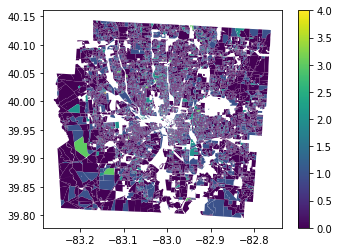

In [70]:
import matplotlib.pyplot as plt

data_block_new = data_block.merge(uniques[['GEOID10', 'UNI']], how='left', on=['GEOID10'])
fig, ax = plt.subplots(1, 1)
data_block_new.plot(column='UNI', ax=ax, legend=True)

####**Check LP metric**
Wieland, S. C., Cassa, C. A., Mandl, K. D., & Berger, B. (2008). Revealing the spatial distribution of a disease while preserving privacy. Proceedings of the National Academy of Sciences, 105(46), 17608-17613.

Privacy measure: probability that any chosen member of the population belong to the target population